# MSPAC Fitting Procedure

> Joseph P. Vantassel, The University of Texas at Austin

Simple example to demonstrate tMSPAC data fitting procedure.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import swprocess

## Create Example Data Set
---

### Create Synthetic Dispersion Data

c:\users\joe\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


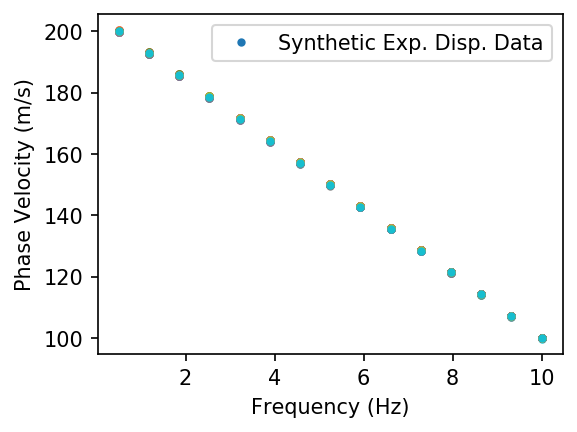

In [2]:
rng = np.random.default_rng(1824)

n = 15
frqs = np.linspace(0.5, 10, n)
mean = np.linspace(200, 100, n)
std = mean * np.linspace(0.001, 0.001, n)

cov = np.ones((n, n))
rho = 5
std2 = std*std
rho2 = rho*rho
for row, f in enumerate(frqs):
    diff = f-frqs
    cov[row] = std2*np.exp(-0.5*diff*diff/rho2)

edd = rng.multivariate_normal(mean=mean, cov=cov, size=(30), tol=1E-6)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)

label = "Synthetic Exp. Disp. Data"
for ed in edd:
    ax.plot(frqs, ed, marker=".", linestyle="", label=label)
    label = ""

ax.legend(loc="upper right")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Phase Velocity (m/s)")
plt.show()

### Compute Implied SPAC Ratios

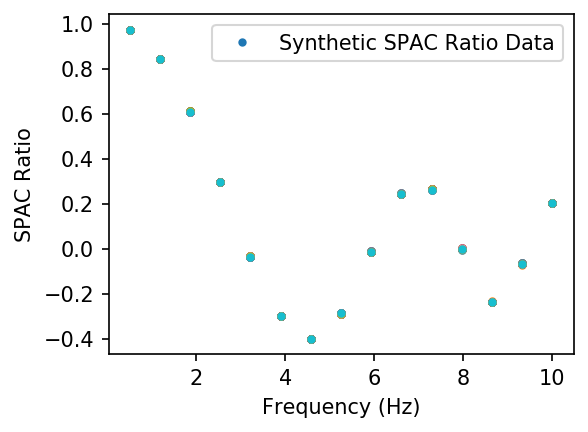

In [3]:
# Assume data came from the vertical component of a ring spanning 20 - 22 m.
meta = dict(component=0, dmin=20, dmax=22)
spac_ratio_fxn = swprocess.SpacCurve.theoretical_spac_ratio_function_general(**meta)
meta["ring"] = 0
meta["time"] = "0"
spaccurve = swprocess.SpacCurve(frqs, spac_ratio_fxn(frqs, edd[0]), **meta)
spaccurvesuite = swprocess.SpacCurveSuite(spaccurve)
for index, _edd in enumerate(edd[1:], 1):
    spaccurve = swprocess.SpacCurve(frqs, spac_ratio_fxn(frqs, edd[index]), **meta)
    spaccurvesuite.append(spaccurve)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
label = "Synthetic SPAC Ratio Data"
for spaccurve in spaccurvesuite:
    ax.plot(spaccurve.frequencies, spaccurve.ratios, marker=".", linestyle="", label=label)
    label = ""
    
ax.legend(loc="upper right")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("SPAC Ratio")
plt.show()

## Transform Snythetic Spac Ratio Data back to the Phase Velocity Space
---

### Calculate SPAC Ratio Statistics

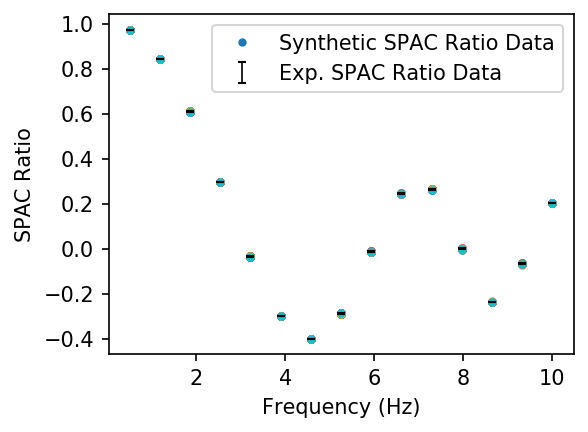

In [4]:
spac_frq, spac_mean, spac_std, _ = spaccurvesuite._calc_spac_ratio_stats()

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
label = "Synthetic SPAC Ratio Data"
for spaccurve in spaccurvesuite:
    ax.plot(spaccurve.frequencies, spaccurve.ratios, marker=".", linestyle="", label=label)
    label = ""
    
ax.errorbar(spac_frq, spac_mean, yerr=spac_std, color="k", linestyle="", zorder=6, capsize=2, linewidth=0.8, label="Exp. SPAC Ratio Data")

ax.legend(loc="upper right")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("SPAC Ratio")
plt.show()

### Transform SPAC Ratio Statistics to Phase Velocity Statistics using Non-linear Least Squares

0.192319505258
0.94826164199
0.948809234687
0.948813122452
0.192176005007
0.683059001946
0.659909391717
0.867090029855
0.945238085746
0.948813108896
9


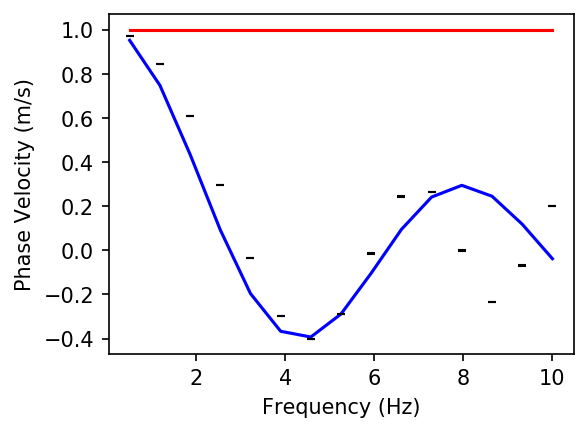

In [25]:
vel_frq, vel_mean, vel_std, vel_corr = spaccurvesuite._to_phase_stat(p0=150, p0_std=150, omega=100, iterations=10, tol=0.01)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)

ax.errorbar(spac_frq, spac_mean, yerr=spac_std, color="k", linestyle="", zorder=6, capsize=2, linewidth=0.8, label="Exp. SPAC Ratio Data")

ax.plot(spac_frq, spac_ratio_fxn(spac_frq, 150), color="b", linestyle="-")

ax.plot(spac_frq, spac_ratio_fxn(spac_frq, vel_mean), color="r", linestyle="-")

# ax.plot(spac_frq, spac_ratio_fxn(spac_frq, np.linspace(200, 100, n)))

# ax.errorbar(vel_frq, vel_mean, yerr=vel_std, color="k", linestyle="", zorder=6, capsize=2, linewidth=0.8, label="Implied Exp. Disp. Data")

# ax.plot(frqs, mean, color="r", linestyle="-")
# ax.plot(frqs, mean+std, color="r", linestyle="--")
# ax.plot(frqs, mean-std, color="r", linestyle="--")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Phase Velocity (m/s)")
plt.show()